# CIFAR-10 Deep Convolutional Neural Network and Optimizations
I originally resisted writing documentation on this, but since this is really the predecessor to the end of chapter assignent for building a face detector, and since I put in a ton of work into understanding CNN's and even trying out and testing different models, it was really worth developing some good documentation for this and I built a variety of links to really useful examples and documentation. 

The [CIFAR (Canadian Institute For Advanced Research)](https://www.cs.toronto.edu/~kriz/cifar.html) CIFAR-10 dataset is a big focus of the chapter. It was collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton. Alex Krizhevsky was the author of the seminal paper in using Convolutional Neural Networks (CNN) for Deep Learning and Image Classification. The [paper from NIPS 2012 - ImageNet Classification with Deep Convolutional Neural Networks](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf) is a seminal paper and has been cited 40,000+ times. In the paper, Krizhevsky talks about many of the foundational building blocks that Nishant covers in Chapter 9 in the book. For example, he introduces:

   1. Deep Layered Architectures and Convolutions for Image Recognition.
   2. The use of Rectifying Linear Unit (ReLU) as a mechanism for smoothing out activation of neurons as particular well suited to image processing.
   3. Image Augmentation activities including flipping the image left and right, rotating it, adding salt and pepper, etc.
   4. Adding MaxPool layers after the Convolutional Layers. 
   5. Batch Normalization technique to smooth out the learning process.
   
The chapter is focused on teaching us basically what is a variation of `AlexNet`, which is Krizhevsky's famous CNN architecture for image processing. Besides using it for CIFAR-10, `AlexNet` was used to win the ImageNet 2012 challenge. [ImageNet](http://www.image-net.org/) is a corpora of millions of images labeled with the [WordNet](https://wordnet.princeton.edu/) taxonomy with 1000 classes. 

I focused a lot early on in the chapter just figuring out what convolutions actually do. They scan an image L-R, then T-B, using a window of a particular `size` which turns out to be the size of the feature vector. In this case, it is `[W x H x C x Cv]` where `W` is conv width, `H` is conv height, `C` is num channels and `Cv` is the number of convolutional filters. The original RGB CIFAR images have `C=3`, however, one of the early image cleansing functions taught in the book is to turn the images to greyscale, or `C=1`. Funny enough many of the examples I found online for CIFAR just went ahead and used the RGB channels - all 3 - as they were. I believe this is likely due to the fact that you can learn something about CIFAR's 10 classes, `[airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck]` based on the color channels too. The `Cv` parameter is an interesting one. It is basically a hyper parameter, since the book uses different ones, e.g., `32`, I've seen `64` (and ended up using it based on online examples). Also the density of the network's "deepness" is also really a learned parameter. The convolutions and max pool layers after that is really a representation of the lower level at first (e.g., curves, lines, triangles/angles) and then eventually higher level features (paws, wheels, etc.). 

Probably my big ah-ha moment was reading this amazing [Beginner's Guide to Understanding Convolutional Neural Networks](https://adeshpande3.github.io/A-Beginner%27s-Guide-To-Understanding-Convolutional-Neural-Networks/) by [Adit Deshpande (UCLA CS Student)](https://adeshpande3.github.io/adeshpande3.github.io/). Fantastic way to understand CNN's and I fully recommend it.

After building a basic convolution network with [Listing 9.11-16](Listing%209.11%20-%209.16.ipynb) in the book, I was able to achieve a `77% ROC micro-average accuracy` across the 10 classes, and on some (`automobiles`) as high as `85%`. What was amazing though was to even do a 1000-epoch training with batch size set to `250`, it took around 30+ hours to train on my local CPU (MacBook Pro 2.9 GHz Intel Core i9 32 GB 2400 MHz DDR4 RAM). I had to basically get some GPU time on a supercomputer to train it in a few hours. My test / evaluation accuracy performance was lower though in the `59%` range. In the book it then suggests adding any of the following to the example:

   1. Augmenting data - I did this, see above and the `augment` function below. I lifted the `sp_noise` function from the [linked example](https://stackoverflow.com/questions/22937589/how-to-add-noise-gaussian-salt-and-pepper-etc-to-image-in-python-with-opencv).
   2. Early stopping - I could see why this is important, I could have implemented a simple check that showed when the loss only changes by a very small fraction across iterations and stopped, but I didn't.
   3. Regularizing weights—I found a [great tutorial on Regularization using TF native functions](https://www.ritchieng.com/machine-learning/deep-learning/tensorflow/regularization/) and applied it - easier than the earlier example in the book.
   4. Dropout—Figuring out what layer to use this in is the most important. Using it in the FC (fully connected layers) worked best for this CNN architecture I was testing.
   5. Deeper architecture — I found quite a few examples of other Deep architectures and CNNs using Tensorflow, and Keras, and other examples for CIFAR-10. I'll detail some of the take-aways below, but the new `model()` function is literally lifted from [this fantastic tutorial](https://towardsdatascience.com/cifar-10-image-classification-in-tensorflow-5b501f7dc77c).
   
After making these series of updates, I was able to get to a `80% ROC micro-average accuracy` and to a test accuracy of `64%`, which were some nice improvements. I also added some code to "test it in the wild" on random image URLs and it performed decent. I'll explain the motivation and some of the cool links and architectures I found that influenced the final solution.

## Towards Data Science CIFAR-10 CNN
[This particular CNN notebook](https://towardsdatascience.com/cifar-10-image-classification-in-tensorflow-5b501f7dc77c) was fantastic and easy to understand. It's a deep architecture, keeps the images as color, has some great tutorials on what the data actually looks like and what the transforms are doing. It also has a [great graphic](https://miro.medium.com/max/504/1*SmfhKWHXHVEMg8KqNaj-uw.gif) of what is actually happening during training, weight updates, and back propagation. Some aspects of this notebook are that it achieved ~`75%` prediction accuracy during training, but overall during testing was only about `59%`. I really liked the way it displayed predictions [as shown at the bottom of this notebook](https://github.com/deep-diver/CIFAR10-img-classification-tensorflow/blob/master/CIFAR10_image_classification.ipynb), so I incorporated that into the `evaluate_model` function at the end of the notebook. The dense architecture incorporates dropout, batch normalization, but doesn't use regularization. It also doesn't do data augmentation. In my own version of it, I added these. The architecture of this network is shown below.
![ch09-cnn-arch](figs/ch09-cnn-arch.png)

## Tensorflow's own Deep CNN CIFAR-10 Tutorial
Tensorflow itself publishes [its own Deep CNN CIFAR-10 Tutorial](https://www.tensorflow.org/tutorials/images/deep_cnn). The things I learned from this tutorial are:
   1. How to perform data augmentation, e.g, Tensorflow's own [tf.random_crop](https://www.tensorflow.org/api_docs/python/tf/image/random_crop), and other functions including [tf.random_flip_left_right](https://www.tensorflow.org/api_docs/python/tf/image/random_flip_left_right), and other things. The great things about these functions is that they operate on tensors, but that also suggests that you need a sort of lazy preprocessing that I didn't feel like implementing and lazy iterators that they use in their notebooks. All advanced stuff, but not necessary for my own exploration. 
   2. How to elegantly use `tf.scope` (like we did during the Ch07 AutoEncoder work) to separate out the training and testing/eval portions of the work. 
   3. A [deep CNN model architecture](https://github.com/tensorflow/models/blob/master/tutorials/image/cifar10/cifar10.py#L163) very similar to the towards data science model previously shown but also does not use as many convolutions. The architecture is shown below.
   4. How to train with multiple-GPUs (elegant, as shown in [here](https://www.tensorflow.org/tutorials/images/deep_cnn#launching_and_training_the_model_on_multiple_gpu_cards)).
   
Overall a very useful tutorial and suggests that at peak can achieve `86%` accuracy with a few hours of training on GPUs (I am still in the process of testing this out).
![ch09-tensorflow-cnn](https://www.tensorflow.org/images/cifar_graph.png)

## Keras Based CIFAR-10 Deep Learning Tutorial
This [fantastic tutorial](https://appliedmachinelearning.blog/2018/03/24/achieving-90-accuracy-in-object-recognition-task-on-cifar-10-dataset-with-keras-convolutional-neural-networks/) shows how to use [Keras](http://keras.io) for creating a CIFAR-10 Deep Learning CNN. Some of the cool properties about it include:

   1. They do data augmentation using Keras's own [ImageDataGenerator](https://keras.io/preprocessing/image/) which can also be used in Tensorflow. I later found a great tutorial on this [here](https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/).
   2. They use regularization.
   3. They use dropout.
   4. Their network architecture is similar, but also smaller compared to the Deep 14 layer architecture I ended up implementing. 
   5. They use batch normalization.
   6. They show Keras looks a lot like Tensorflow and they can even work together.
   
According to their results, the model achieves `90%` accuracy though I haven't verified this.
![ch09-keras-cnn](https://i0.wp.com/appliedmachinelearning.blog/wp-content/uploads/2018/03/cnn.png?zoom=2&resize=698%2C282&ssl=1)

## Conclusion 
I spent so much time on trying to nail CIFAR-10, that the face detection end of chapter assignemnt became sort of an afterthought. I figured if I could implement all the extras and do all the extra research in this assignment that it would pay off in the end. We'll see I'm still working on the end of chapter assignment. Some nice things I did in this notebook:

   1. My model includes all of the suggested improvements, save early stopping (e.g., Augmentation, Regularization, Deeper Architecture, Dropout, and I even added Batch Normalization). 
   2. I added simple predict functions.
   3. I incorporated ROC curves to understand how well the model is performing per class.
   
Enjoy!

## References

   0. [The CIFAR-10 and CIFAR-100 Datasets](https://www.cs.toronto.edu/~kriz/cifar.html)
   1. [Data Augmentation and PyImageSearch](https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/)
   2. [AlexNet Wikipedia Article](https://en.wikipedia.org/wiki/AlexNet) and [Seminal AlexNet paper from NIPS 2012](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf)
   3. [Data Augmentation - Adding Gaussian Noise to an Image](https://stackoverflow.com/questions/22937589/how-to-add-noise-gaussian-salt-and-pepper-etc-to-image-in-python-with-opencv)
   4. [Data Augmentation - Random Image Crop and Tensorflow](https://stackoverflow.com/questions/42147427/tensorflow-how-to-randomly-crop-input-images-and-labels-in-the-same-way)
   5. [Data Augmentation - Random Image Flip](https://stackoverflow.com/questions/9154120/how-can-i-flip-an-image-along-the-vertical-axis-with-python)
   6. [Data Augmentation - Great SkImage Tutorial on Image Processing](https://scikit-image.org/docs/dev/user_guide/transforming_image_data.html)
   7. [Data Augmentation - SkImage More Documentation](https://scikit-image.org/docs/dev/api/skimage.util.html)
   8. [Deep Architecture - Tensorflow CIFAR-10 Tutorial Multi GPUs](https://github.com/tensorflow/models/blob/master/tutorials/image/cifar10/cifar10_multi_gpu_train.py)
   9. [Representing the Answer - how to use MatplotLib for Multi-class Classification and ROC curves](https://scikit-learn.org/0.15/auto_examples/plot_roc.html)
   10. [How to get a Tensor by Name - Tensorflow](https://stackoverflow.com/questions/36612512/tensorflow-how-to-get-a-tensor-by-name)
   11. [Regularization Tutorial using Tensorflow and Multi-class](https://www.ritchieng.com/machine-learning/deep-learning/tensorflow/regularization/)
   12. [Testing the Model - Turning an Image URL into a usable Numpy Array](https://www.pyimagesearch.com/2015/03/02/convert-url-to-image-with-python-and-opencv/)
   13. [Data Augmentation - use SkImage to rescale an Image](https://stackoverflow.com/questions/48121916/numpy-resize-rescale-image)
   14. [Keras - A fantastic CIFAR-10 tutorial on how to design CNN models and how to decide when and where to add improvement steps](https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/)
   15. [Data Augmentation - Using Scipy for Imae processing](http://scipy-lectures.org/advanced/image_processing/)
   16. [Diff between tf.contrib.flatten_layers and resizing using np](https://stackoverflow.com/questions/49406654/tf-reshape-vs-tf-contrib-layers-flatten)
   17. [Deep Architecture - Fantastic Towards Data Science Tutorial](https://towardsdatascience.com/cifar-10-image-classification-in-tensorflow-5b501f7dc77c) and its associated [notebook](https://github.com/deep-diver/CIFAR10-img-classification-tensorflow/blob/master/CIFAR10_image_classification.ipynb)
   18. [The Vanishing Gradient Problem and Why we do Regularization and other Steps](https://en.wikipedia.org/wiki/Vanishing_gradient_problem)  

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle
import random
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from skimage.transform import resize
from skimage.io import imread
from skimage import color
import os
import cv2

In [2]:
def unpickle(file):
    fo = open(file, 'rb')
    dict = pickle.load(fo, encoding='latin1')
    fo.close()
    return dict

In [3]:
def sp_noise(image,prob):
    '''
    Add salt and pepper noise to image
    prob: Probability of the noise
    '''
    output = np.zeros(image.shape,np.float32)
    thres = 1 - prob 
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rdn = random.random()
            if rdn < prob:
                output[i][j] = 0.
            elif rdn > thres:
                output[i][j] = 255.
            else:
                output[i][j] = image[i][j]
    return output

In [4]:
def augment(img_data, img_labels):
    imgs = img_data.reshape(img_data.shape[0], 3, 32, 32)
    flip_pct = 0.05 # 5% chance of flipping the image each time
    salt_pct = 0.05 # 5% chance of noise
    noise_pct = 0.15 # salt and pepper noise
    
    orig_size = len(imgs)
    for i in tqdm(range(0, orig_size)):
        # random flip UD (which will in effect do the LR flip)
        if random.random() < flip_pct:
            #print('IMFLIP: im['+str(i)+']')
            im_flip = np.expand_dims(np.flipud(imgs[i]), axis=0)
            imgs = np.vstack((imgs, im_flip))
            img_labels = np.hstack((img_labels, img_labels[i]))
        
        # random salt and pepper noise
        if random.random() < salt_pct:
            #print('IMSALT: im['+str(i)+']')
            im_salt = np.expand_dims(sp_noise(imgs[i], noise_pct), axis=0)
            imgs = np.vstack((imgs, im_salt))
            img_labels = np.hstack((img_labels, img_labels[i]))
            
    return imgs.reshape(imgs.shape[0], -1), img_labels


In [5]:
def clean(data):
    imgs = data.reshape(data.shape[0], 3, 32, 32)
    grayscale_imgs = imgs.mean(1)
    cropped_imgs = grayscale_imgs[:, 4:28, 4:28]
    img_data = cropped_imgs.reshape(imgs.shape[0], -1)
    img_size = np.shape(img_data)[1]
    means = np.mean(img_data, axis=1)
    meansT = means.reshape(len(means), 1)
    stds = np.std(img_data, axis=1)
    stdsT = stds.reshape(len(stds), 1)
    adj_stds = np.maximum(stdsT, 1.0 / np.sqrt(img_size))
    normalized = (img_data - meansT) / adj_stds
    return normalized

In [6]:
def read_data(directory):
    data_file = 'aug_data.npy'
    labels_file = 'aug_labels.npy'

    names = unpickle('{}/batches.meta'.format(directory))['label_names']
    print('names', names)
    data, labels = [], []
    
    if os.path.exists(data_file) and os.path.isfile(data_file) and os.path.exists(labels_file) and os.path.isfile(labels_file):
            print('Loading data from cache files {} and {}'.format(data_file, labels_file))
            data = np.load(data_file)
            labels = np.load(labels_file)
    else:
        for i in range(1, 6):
            filename = '{}/data_batch_{}'.format(directory, i)
            batch_data = unpickle(filename)
            if len(data) > 0:
                data = np.vstack((data, batch_data['data']))
                labels = np.hstack((labels, batch_data['labels']))
            else:
                data = batch_data['data']
                labels = batch_data['labels']

        data, labels = augment(data, labels)
        data = clean(data)        
        data = data.astype(np.float32)
        np.save('aug_data.npy', data)
        np.save('aug_labels.npy', labels)

    print(np.shape(data), np.shape(labels))

    return names, data, labels


In [7]:
# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

names, data, labels = read_data('./cifar-10-batches-py')
x = tf.placeholder(tf.float32, [None, 24 * 24], name='input_x') # 5000,576
y = tf.placeholder(tf.float32, [None, len(names)], name='output_y') # 50000, 10
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

names ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Loading data from cache files aug_data.npy and aug_labels.npy
(55153, 576) (55153,)


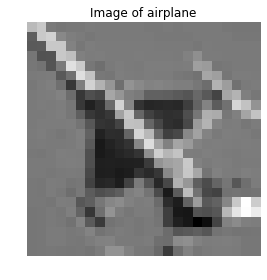

In [8]:
plt.figure()
plt.title("Image of "+str(names[labels[52001]]))
img = np.reshape(data[52001, :], (24,24))
plt.imshow(img, cmap='Greys_r')
plt.axis('off')
plt.tight_layout()

In [9]:
conv1_filter = tf.Variable(tf.truncated_normal(shape=[3, 3, 1, 64], mean=0, stddev=0.08)) #changed 3 to 1 in 3rd param b/c Grey
conv2_filter = tf.Variable(tf.truncated_normal(shape=[3, 3, 64, 128], mean=0, stddev=0.08))
conv3_filter = tf.Variable(tf.truncated_normal(shape=[5, 5, 128, 256], mean=0, stddev=0.08))
conv4_filter = tf.Variable(tf.truncated_normal(shape=[5, 5, 256, 512], mean=0, stddev=0.08))

Instructions for updating:
Colocations handled automatically by placer.


In [10]:
def model(x, keep_prob):
    x_reshaped = tf.reshape(x, shape=[-1, 24, 24, 1])
    
    # 1, 2
    conv1 = tf.nn.conv2d(x_reshaped, conv1_filter, strides=[1,1,1,1], padding='SAME')
    conv1 = tf.nn.relu(conv1)
    conv1_pool = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    conv1_bn = tf.layers.batch_normalization(conv1_pool)

    # 3, 4
    conv2 = tf.nn.conv2d(conv1_bn, conv2_filter, strides=[1,1,1,1], padding='SAME')
    conv2 = tf.nn.relu(conv2)
    conv2_pool = tf.nn.max_pool(conv2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')    
    conv2_bn = tf.layers.batch_normalization(conv2_pool)
  
    # 5, 6
    conv3 = tf.nn.conv2d(conv2_bn, conv3_filter, strides=[1,1,1,1], padding='SAME')
    conv3 = tf.nn.relu(conv3)
    conv3_pool = tf.nn.max_pool(conv3, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')  
    conv3_bn = tf.layers.batch_normalization(conv3_pool)
    
    # 7, 8
    conv4 = tf.nn.conv2d(conv3_bn, conv4_filter, strides=[1,1,1,1], padding='SAME')
    conv4 = tf.nn.relu(conv4)
    conv4_pool = tf.nn.max_pool(conv4, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
    conv4_bn = tf.layers.batch_normalization(conv4_pool)
    
    # 9
    flat = tf.contrib.layers.flatten(conv4_bn)  

    # 10
    full1 = tf.contrib.layers.fully_connected(inputs=flat, num_outputs=128, activation_fn=tf.nn.relu)
    full1 = tf.nn.dropout(full1, keep_prob)
    full1 = tf.layers.batch_normalization(full1)
    
    # 11
    full2 = tf.contrib.layers.fully_connected(inputs=full1, num_outputs=256, activation_fn=tf.nn.relu)
    full2 = tf.nn.dropout(full2, keep_prob)
    full2 = tf.layers.batch_normalization(full2)
    
    # 12
    full3 = tf.contrib.layers.fully_connected(inputs=full2, num_outputs=512, activation_fn=tf.nn.relu)
    full3 = tf.nn.dropout(full3, keep_prob)
    full3 = tf.layers.batch_normalization(full3)    
    
    # 13
    full4 = tf.contrib.layers.fully_connected(inputs=full3, num_outputs=1024, activation_fn=tf.nn.relu)
    full4 = tf.nn.dropout(full4, keep_prob)
    full4 = tf.layers.batch_normalization(full4)        
    
    # 14
    out = tf.contrib.layers.fully_connected(inputs=full4, num_outputs=10, activation_fn=None)
    return out

In [11]:
epochs = 1000
keep_probability = 0.7
learning_rate = 0.001
model_op = model(x, keep_probability)
model_ops = tf.identity(model_op, name='logits') # Name logits Tensor, so that can be loaded from disk after training
beta = 0.1 #regularlization
weights = [conv1_filter, conv2_filter, conv3_filter, conv4_filter]
regularizer = tf.nn.l2_loss(weights[0])
for w in range(1, len(weights)):
    regularizer = regularizer + tf.nn.l2_loss(weights[w])

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=model_op, labels=y))
cost = tf.reduce_mean(cost + beta * regularizer) #L2 regularization
train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
correct_pred = tf.equal(tf.argmax(model_op, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

Instructions for updating:
Use keras.layers.batch_normalization instead.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [12]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    onehot_labels = tf.one_hot(labels, len(names), on_value=1., off_value=0., axis=-1)
    onehot_vals = sess.run(onehot_labels)
    batch_size = len(data) // 200
    print('batch size', batch_size)
    for j in tqdm(range(0, epochs)):
        for i in range(0, len(data), batch_size):
            batch_data = data[i:i+batch_size, :]
            batch_onehot_vals = onehot_vals[i:i+batch_size, :]
            _, accuracy_val = sess.run([train_op, accuracy], feed_dict={x:batch_data, y: batch_onehot_vals})
        print(j, accuracy_val)
  

    saver.save(sess, './cifar10-cnn-tf1n-ia-dropout-reg-dense-'+str(epochs)+'epochs.ckpt')

batch size 275


0 0.22875817
1 0.25490198
2 0.32026145
3 0.27450982
4 0.33333334
5 0.3529412
6 0.41830066
7 0.38562092
8 0.47058824
9 0.4640523



In [14]:
def predict(img_data):
    class_num, class_name, confidence = None, None, 0.
    with tf.Session() as sess:
        loaded_graph = tf.Graph()

        with tf.Session(graph=loaded_graph) as sess:
            # Load model
            loader = tf.train.import_meta_graph('./cifar10-cnn-tf1n-ia-dropout-reg-dense-'+str(epochs)+'epochs.ckpt' + '.meta')
            loader.restore(sess, './cifar10-cnn-tf1n-ia-dropout-reg-dense-'+str(epochs)+'epochs.ckpt')

            # Get Tensors from loaded model
            loaded_x = loaded_graph.get_tensor_by_name('input_x:0')
            loaded_y = loaded_graph.get_tensor_by_name('output_y:0')
            loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
            loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
            loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
            
            logits_out = sess.run(tf.nn.softmax(loaded_logits), feed_dict={'input_x:0': img_data.reshape((1, 24*24))})
            class_num = np.argmax(logits_out, axis=1)[0]
            class_name = names[class_num]
            confidence = logits_out[0,class_num]
            all_preds = logits_out
            
            
    return (class_num, class_name, confidence, all_preds)
       

In [15]:
class_num, class_name, confidence, all_preds = predict(data[3])
print('Class Num', class_num)
print('Class', class_name)
print('Confidence', confidence)
print('All Predictions', str(all_preds))

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./cifar10-cnn-tf1n-ia-dropout-reg-dense-1000epochs.ckpt
Class Num 4
Class deer
Confidence 0.9808226
All Predictions [[4.4197081e-05 9.5876167e-05 2.8241586e-03 2.7891779e-03 9.8082262e-01
  7.7252910e-03 8.2551051e-06 5.6511005e-03 6.2668169e-06 3.2982902e-05]]


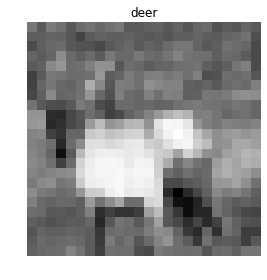

In [16]:
plt.figure()
plt.title(class_name)
img = np.reshape(data[3, :], (24,24))
plt.imshow(img, cmap='Greys_r')
plt.axis('off')
plt.tight_layout()

In [17]:
# test out on test images
def read_test_data(directory):
    names = unpickle('{}/batches.meta'.format(directory))['label_names']
    print('names', names)
    data, labels = [], []
    
    filename = '{}/test_batch'.format(directory)
    batch_data = unpickle(filename)
    if len(data) > 0:
        data = np.vstack((data, batch_data['data']))
        labels = np.hstack((labels, batch_data['labels']))
    else:
        data = batch_data['data']
        labels = batch_data['labels']
    print(np.shape(data), np.shape(labels))
    data = clean(data)
    data = data.astype(np.float32)
    return names, data, labels

In [18]:
test_names, test_data, test_labels = read_test_data('cifar-10-batches-py')

names ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
(10000, 3072) (10000,)


In [19]:
test_class_num, test_class_name, test_class_confidence, all_preds = predict(test_data[4])
print('Test Class Num', test_class_num)
print('Test Class Name', test_class_name)
print('Test Class Confidence', test_class_confidence)
print('All Preds', str(all_preds))
print('Actual Class Label', test_labels[4])

INFO:tensorflow:Restoring parameters from ./cifar10-cnn-tf1n-ia-dropout-reg-dense-1000epochs.ckpt
Test Class Num 6
Test Class Name frog
Test Class Confidence 0.46584144
All Preds [[0.00823252 0.00831128 0.09518484 0.13664137 0.07743814 0.04619991
  0.46584144 0.00137309 0.15620254 0.00457495]]
Actual Class Label 6


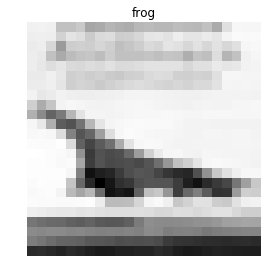

In [20]:
plt.figure()
plt.title(test_class_name)
img = np.reshape(test_data[3, :], (24,24))
plt.imshow(img, cmap='Greys_r')
plt.axis('off')
plt.tight_layout()

In [21]:
def get_test_accuracy(test_data, test_names, test_labels):
    class_num, class_name, confidence = None, None, 0.
    with tf.Session() as sess:
        loaded_graph = tf.Graph()

        with tf.Session(graph=loaded_graph) as sess:
            # Load model
            loader = tf.train.import_meta_graph('./cifar10-cnn-tf1n-ia-dropout-reg-dense-'+str(epochs)+'epochs.ckpt' + '.meta')
            loader.restore(sess, './cifar10-cnn-tf1n-ia-dropout-reg-dense-'+str(epochs)+'epochs.ckpt')

            # Get Tensors from loaded model
            loaded_x = loaded_graph.get_tensor_by_name('input_x:0')
            loaded_y = loaded_graph.get_tensor_by_name('output_y:0')
            loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
            loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
            loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
            onehot_test_labels = tf.one_hot(test_labels, len(test_names), on_value=1., off_value=0., axis=-1).eval()              
            test_logits_out = sess.run(tf.nn.softmax(loaded_logits), feed_dict={'input_x:0': test_data, "output_y:0" :onehot_test_labels, "keep_prob:0": 1.0})       
            test_correct_pred = tf.equal(tf.argmax(test_logits_out, 1), tf.argmax(onehot_test_labels, 1))
            test_accuracy = tf.reduce_mean(tf.cast(test_correct_pred, tf.float32))

            print('Test accuracy %f' % (test_accuracy.eval()))  
            predictions = tf.argmax(test_logits_out, 1).eval()
            return (predictions, tf.cast(test_correct_pred, tf.float32).eval(), onehot_test_labels)

    
predict_vals, test_correct_preds, onehot_test_lbls = get_test_accuracy(test_data, test_names, test_labels)
print(predict_vals)
print(predict_vals.shape)
print(test_correct_preds)
print(test_correct_preds.shape)
print(onehot_test_lbls.shape)

INFO:tensorflow:Restoring parameters from ./cifar10-cnn-tf1n-ia-dropout-reg-dense-1000epochs.ckpt
Test accuracy 0.639700
[3 8 1 ... 5 1 7]
(10000,)
[1. 1. 0. ... 1. 1. 1.]
(10000,)
(10000, 10)


10


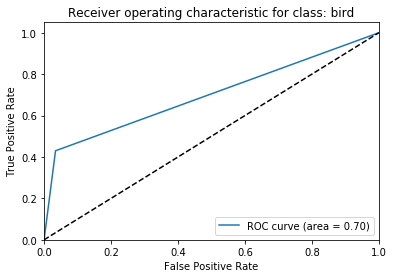

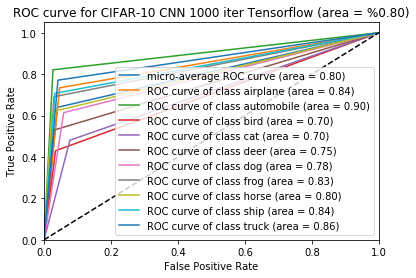

In [22]:
outcome_test = label_binarize(test_labels, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
predictions_test = label_binarize(predict_vals, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
n_classes = outcome_test.shape[1]
print(n_classes)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(outcome_test[:, i], predictions_test[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
   
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(outcome_test.ravel(), predictions_test.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr[2], tpr[2], label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for class: '+test_names[2])
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(test_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
roc_mean = np.mean(np.fromiter(roc_auc.values(), dtype=float))
plt.title('ROC curve for CIFAR-10 CNN '+str(epochs)+' iter Tensorflow (area = %{0:0.2f})'.format(roc_mean))
plt.legend(loc="lower right")
plt.show()

In [23]:
def predict_img_url(url):
    image = color.rgb2gray(imread(url))
    new_size = 24,24
    image = cv2.resize(image, new_size, interpolation=cv2.INTER_CUBIC)
#    print("Cropped to 24x24")
    images = np.expand_dims(image, axis=0)
    im_data = images.astype(np.float32)
    prediction = predict(im_data[0])
    return prediction


In [24]:
predict_urls = [
    'http://www.torontozoo.com/adoptapond/guide_images/Green%20Frog.jpg', #frog
    'https://cdn.cnn.com/cnnnext/dam/assets/160205192735-01-best-cruise-ships-disney-dream-super-169.jpg', #ship
    'https://www.sailboston.com/wp-content/uploads/2016/11/amerigo-vespucci.jpg', #ship
    'https://upload.wikimedia.org/wikipedia/commons/d/d9/Motorboat_at_Kankaria_lake.JPG', #ship
    'https://media.wired.com/photos/5b9c3d5e7d9d332cf364ad66/master/pass/AV-Trucks-187479297.jpg', #truck
    'https://images.schoolspecialty.com/images/1581176_ecommfullsize.jpg', #truck
    'https://img.purch.com/w/660/aHR0cDovL3d3dy5saXZlc2NpZW5jZS5jb20vaW1hZ2VzL2kvMDAwLzEwNC84MTkvb3JpZ2luYWwvY3V0ZS1raXR0ZW4uanBn', # cat
    'https://thehorse.com/wp-content/uploads/2017/01/iStock-510488648.jpg', #horse
    'http://www.portoalegre.travel/upload/b/107/1078782_wallpapers-autos-deportivos.jpg' #car
]

preds=[]
for url in predict_urls:
    pred = predict_img_url(url)
    preds.append(pred)

INFO:tensorflow:Restoring parameters from ./cifar10-cnn-tf1n-ia-dropout-reg-dense-1000epochs.ckpt
INFO:tensorflow:Restoring parameters from ./cifar10-cnn-tf1n-ia-dropout-reg-dense-1000epochs.ckpt
INFO:tensorflow:Restoring parameters from ./cifar10-cnn-tf1n-ia-dropout-reg-dense-1000epochs.ckpt
INFO:tensorflow:Restoring parameters from ./cifar10-cnn-tf1n-ia-dropout-reg-dense-1000epochs.ckpt
INFO:tensorflow:Restoring parameters from ./cifar10-cnn-tf1n-ia-dropout-reg-dense-1000epochs.ckpt
INFO:tensorflow:Restoring parameters from ./cifar10-cnn-tf1n-ia-dropout-reg-dense-1000epochs.ckpt
INFO:tensorflow:Restoring parameters from ./cifar10-cnn-tf1n-ia-dropout-reg-dense-1000epochs.ckpt
INFO:tensorflow:Restoring parameters from ./cifar10-cnn-tf1n-ia-dropout-reg-dense-1000epochs.ckpt
INFO:tensorflow:Restoring parameters from ./cifar10-cnn-tf1n-ia-dropout-reg-dense-1000epochs.ckpt


In [25]:
def evaluate_model(urls, predicted):
    im_data = []
    for url in urls:
        image = color.rgb2gray(imread(url))
        new_size = 24,24
        image = cv2.resize(image, new_size, interpolation=cv2.INTER_CUBIC)
        images = np.expand_dims(image, axis=0)
        if len(im_data) > 0:
            im_data = np.vstack((im_data, images.astype(np.float32)))
        else:
            im_data = images.astype(np.float32)
            
    n_predictions = len(predicted)
    fig, axies = plt.subplots(nrows=n_predictions, ncols=2, figsize=(24, 24))
    fig.tight_layout()
    fig.suptitle('Softmax Predictions for '+str(len(predicted))+' CIFAR-10 CNN '+str(epochs)+' iter Image URLs', fontsize=20, y=1.1)

    n_predictions = 10
    margin = 0.05
    ind = np.arange(n_predictions)
    width = (1. - 2. * margin) / n_predictions
   
    for i in range(0, len(im_data)):
        pred_names = names
        pred_values = predicted[i][3][0]
        correct_name = predicted[i][1]
        
        axies[i][0].imshow(im_data[i], cmap='Greys_r')
        axies[i][0].set_title(correct_name)
        axies[i][0].set_axis_off()

        axies[i][1].barh(ind + margin, pred_values, width)
        axies[i][1].set_yticks(ind + margin)
        axies[i][1].set_yticklabels(pred_names)
        axies[i][1].set_xticks([0, 0.5, 1.0])


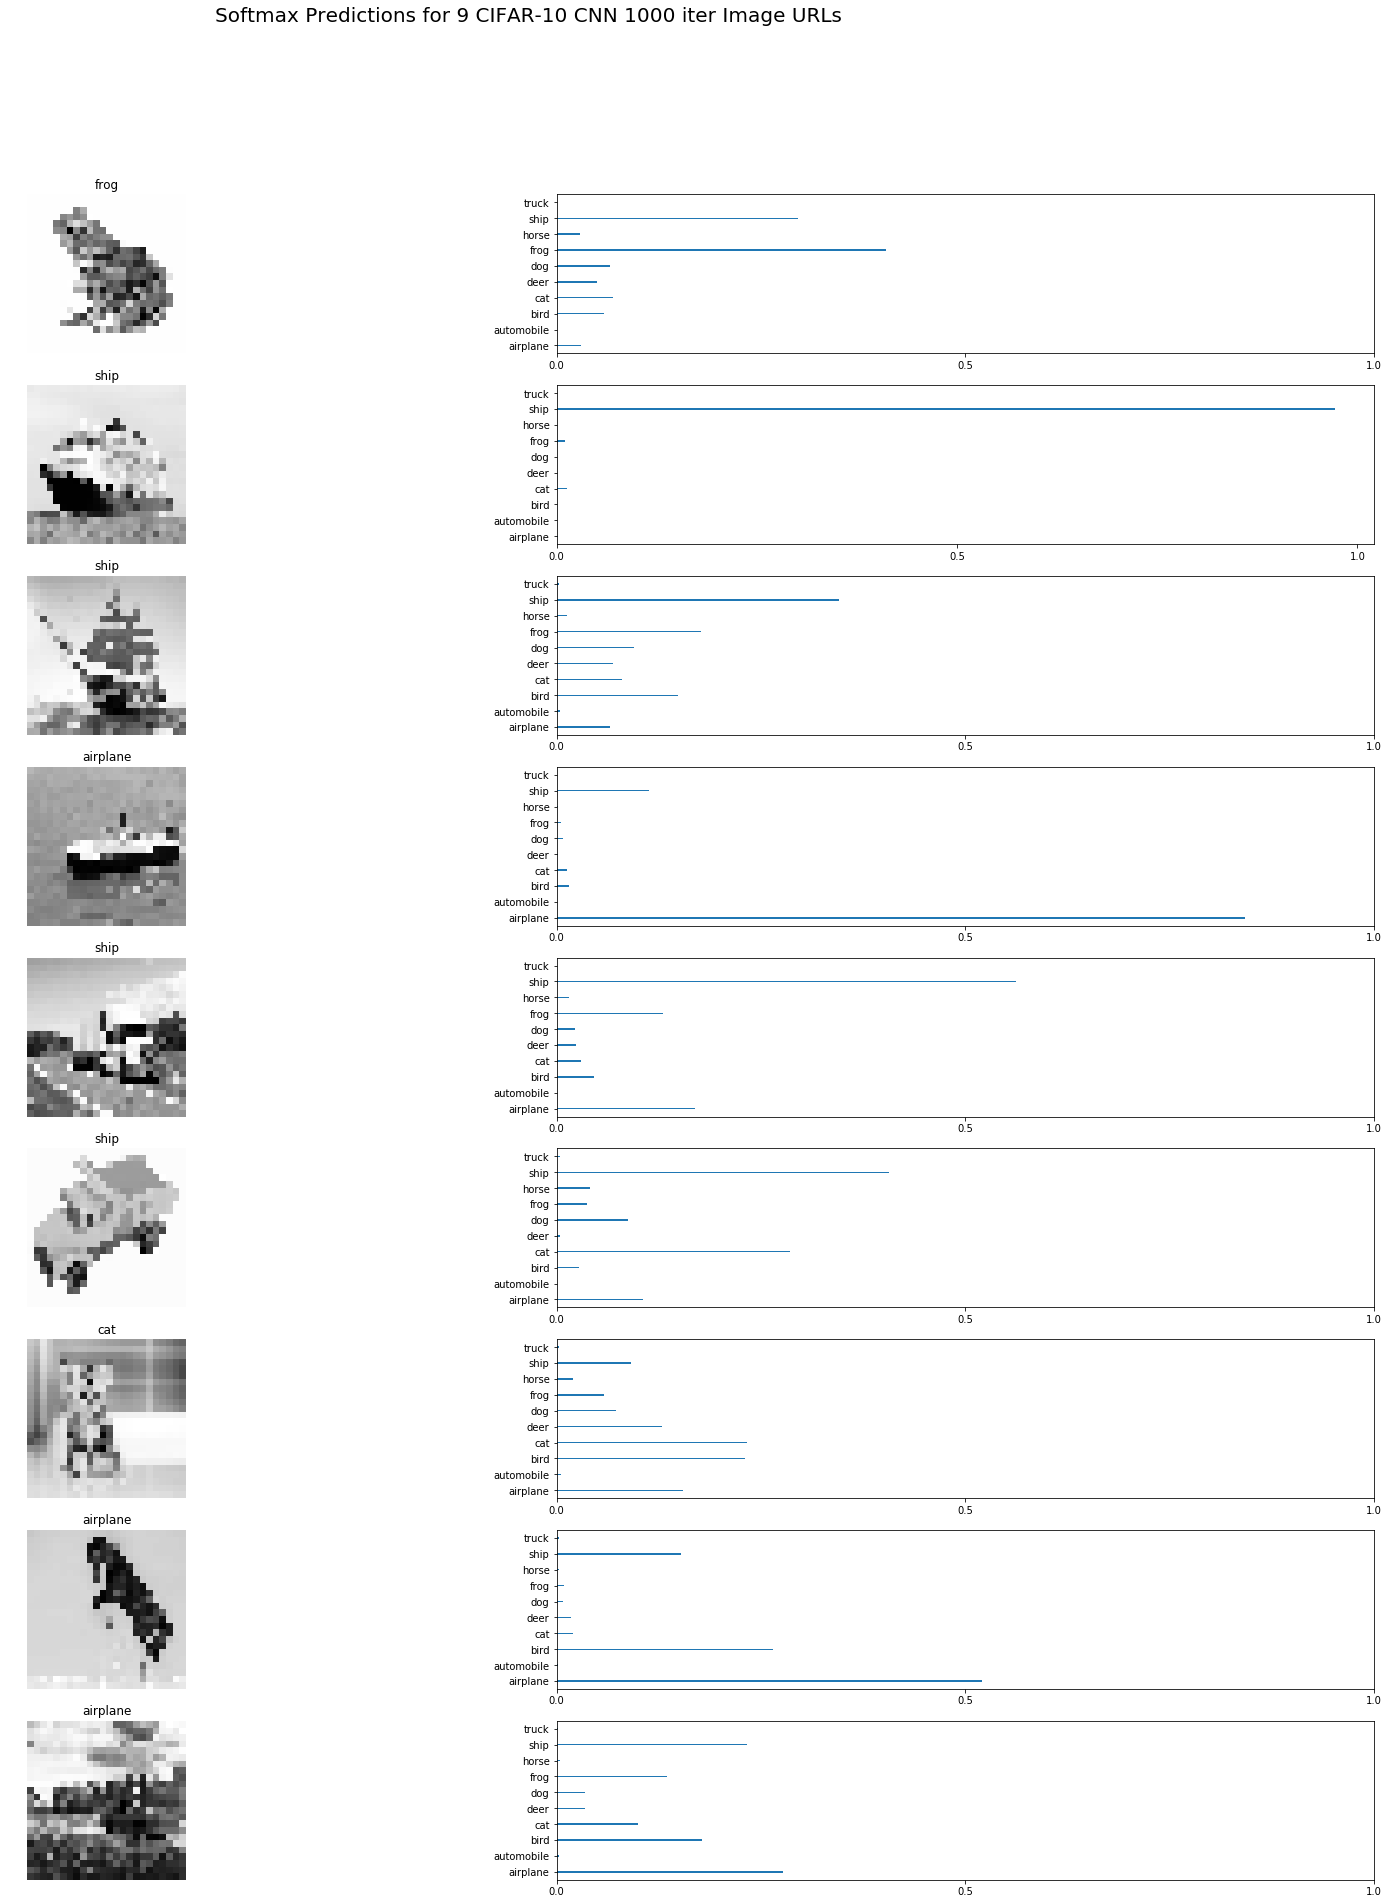

In [26]:
evaluate_model(predict_urls, preds)